In [158]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import warnings
import erddapy
from erddapy import ERDDAP
import xarray_regrid
import rioxarray
from shapely.geometry import mapping
import cartopy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def clip_xr(ds, lon_name, lat_name, shp, projection=None):
    ds.rio.set_spatial_dims(x_dim=lon_name, y_dim=lat_name, inplace=True)
    try:
        ds.rio.write_crs(projection, inplace=True)
    except:
        ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped = ds.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=True)
    return clipped 


In [112]:
e = ERDDAP(
    server='https://coastwatch.noaa.gov/erddap',
    protocol='griddap',)

constraints = {
"time>=": "2023-06-01T00:00:00Z",
"time<=": "2023-06-31T00:00:00Z",
"latitude>=": 34,
"latitude<=": 46,
"longitude>=": -77,
"longitude<=": -63,}
e.dataset_id = 'noaacwNPPN20S3ASCIDINEOF2kmDaily'
e.griddap_initialize()
e.constraints.update(constraints)
chla = e.to_xarray()

In [113]:
e = ERDDAP(
    server='https://coastwatch.noaa.gov/erddap',
    protocol='griddap',)

constraints = {
"time>=": "2023-06-01T00:00:00Z",
"time<=": "2023-06-31T00:00:00Z",
"latitude>=": 34,
"latitude<=": 46,
"longitude>=": -77,
"longitude<=": -63,}
e.dataset_id = 'noaacwL3Collatedn20C'
e.griddap_initialize()
e.constraints.update(constraints)
sst = e.to_xarray()

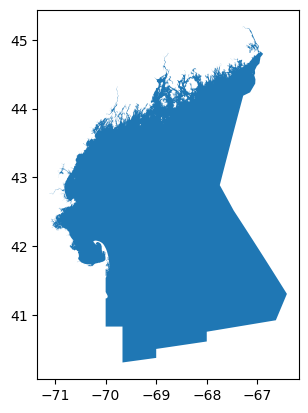

In [114]:
shp = gpd.read_file(r'C:\Users\haley.synan\Documents\SEASCAPES\DATA\SHAPEFILES\GOM-GB_Exemption_Area\GOM-GB_Exemption_Area.shp')
shp.plot()
chla_sub = clip_xr(chla, 'longitude', 'latitude',shp)
sst_sub = clip_xr(sst, 'longitude', 'latitude',shp)

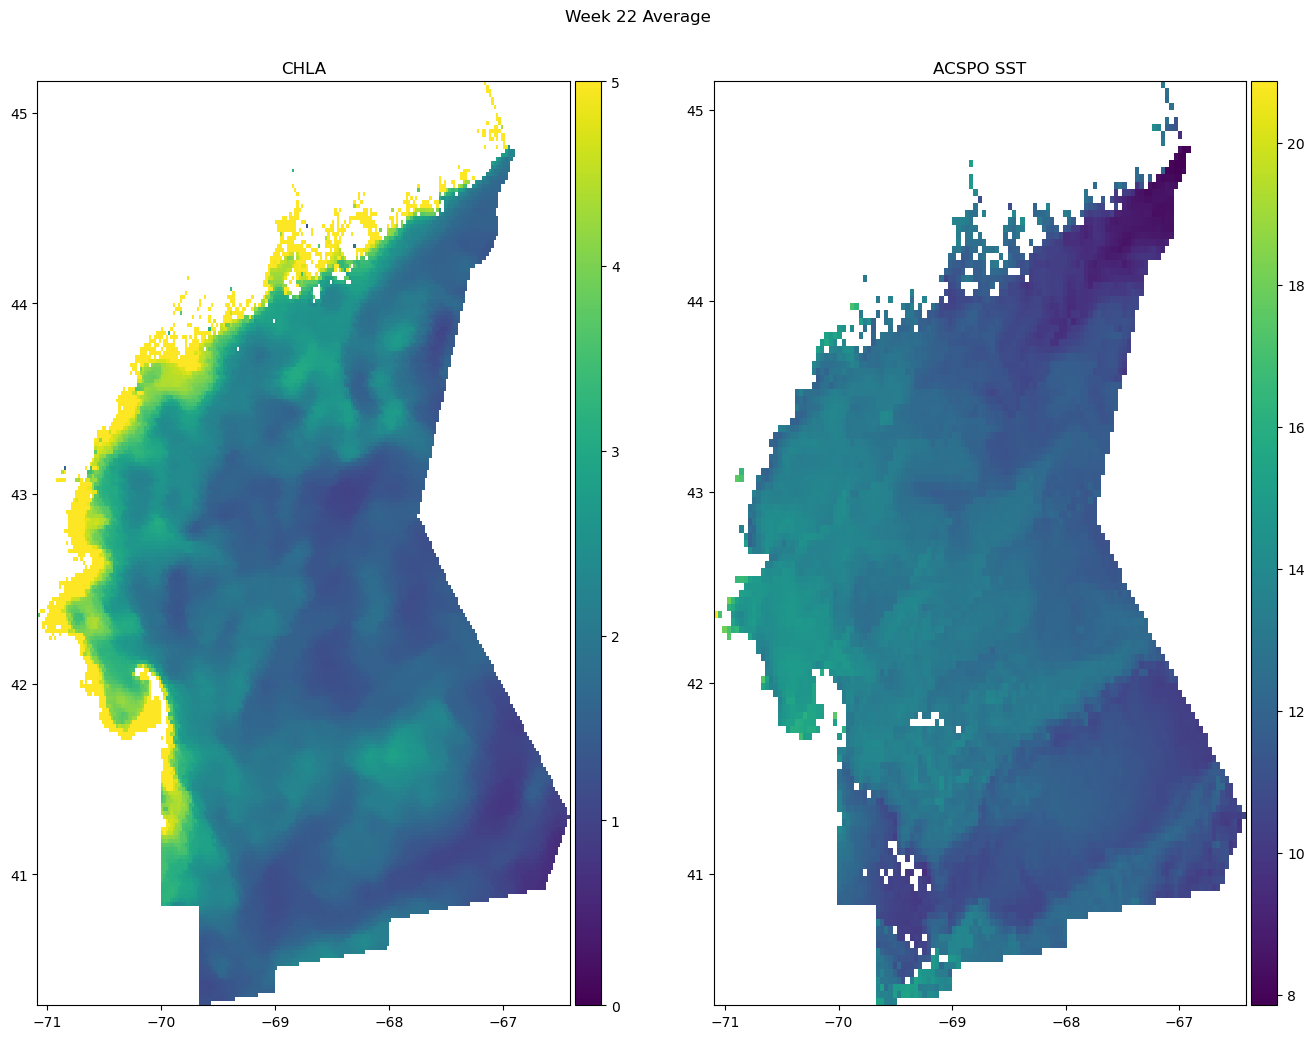

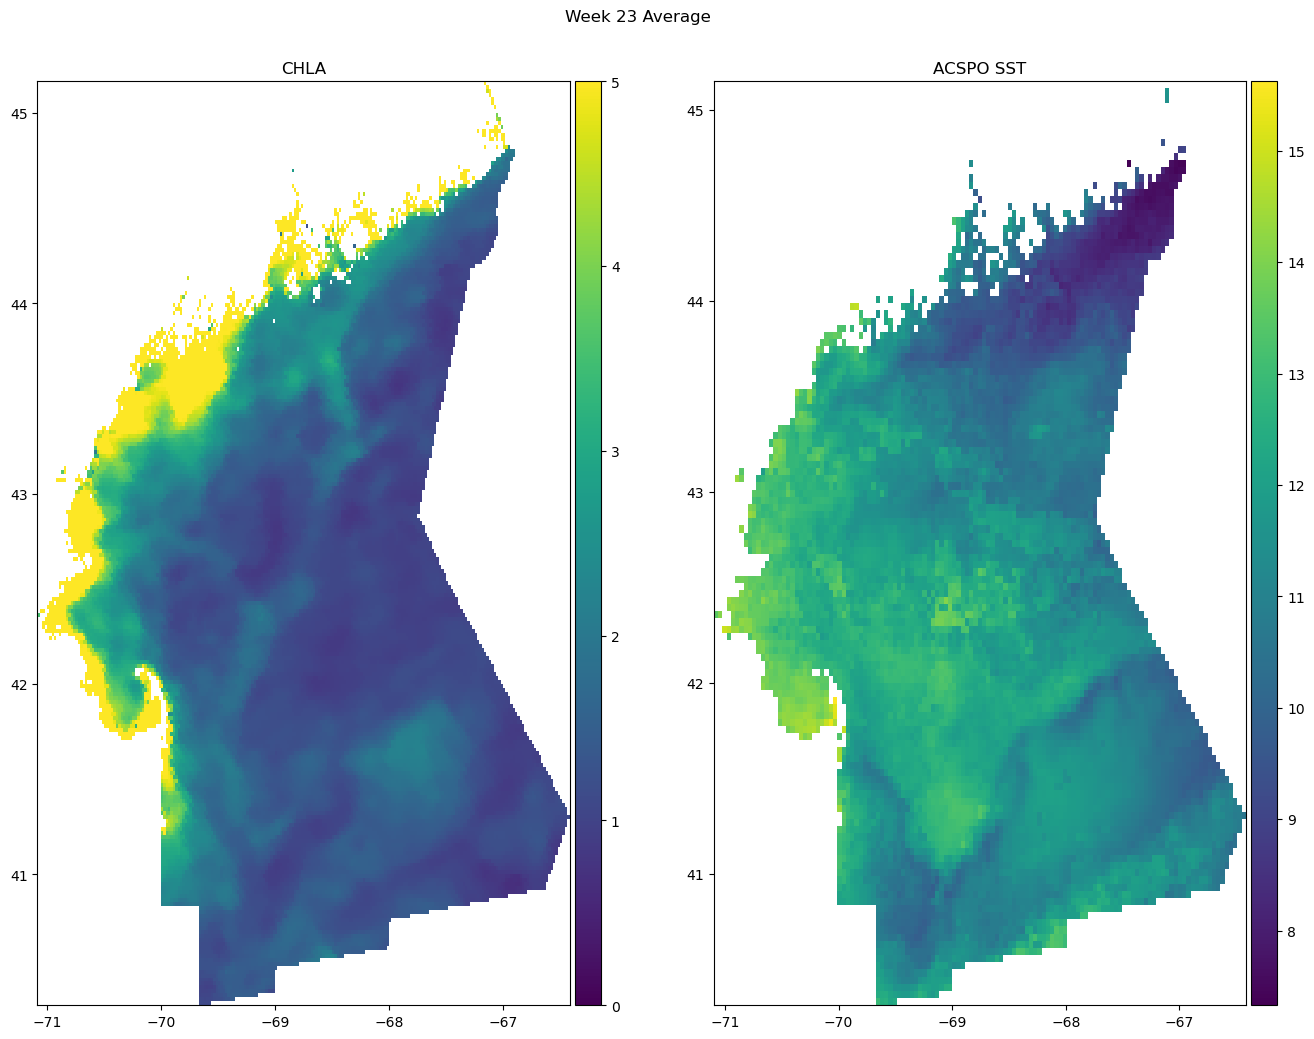

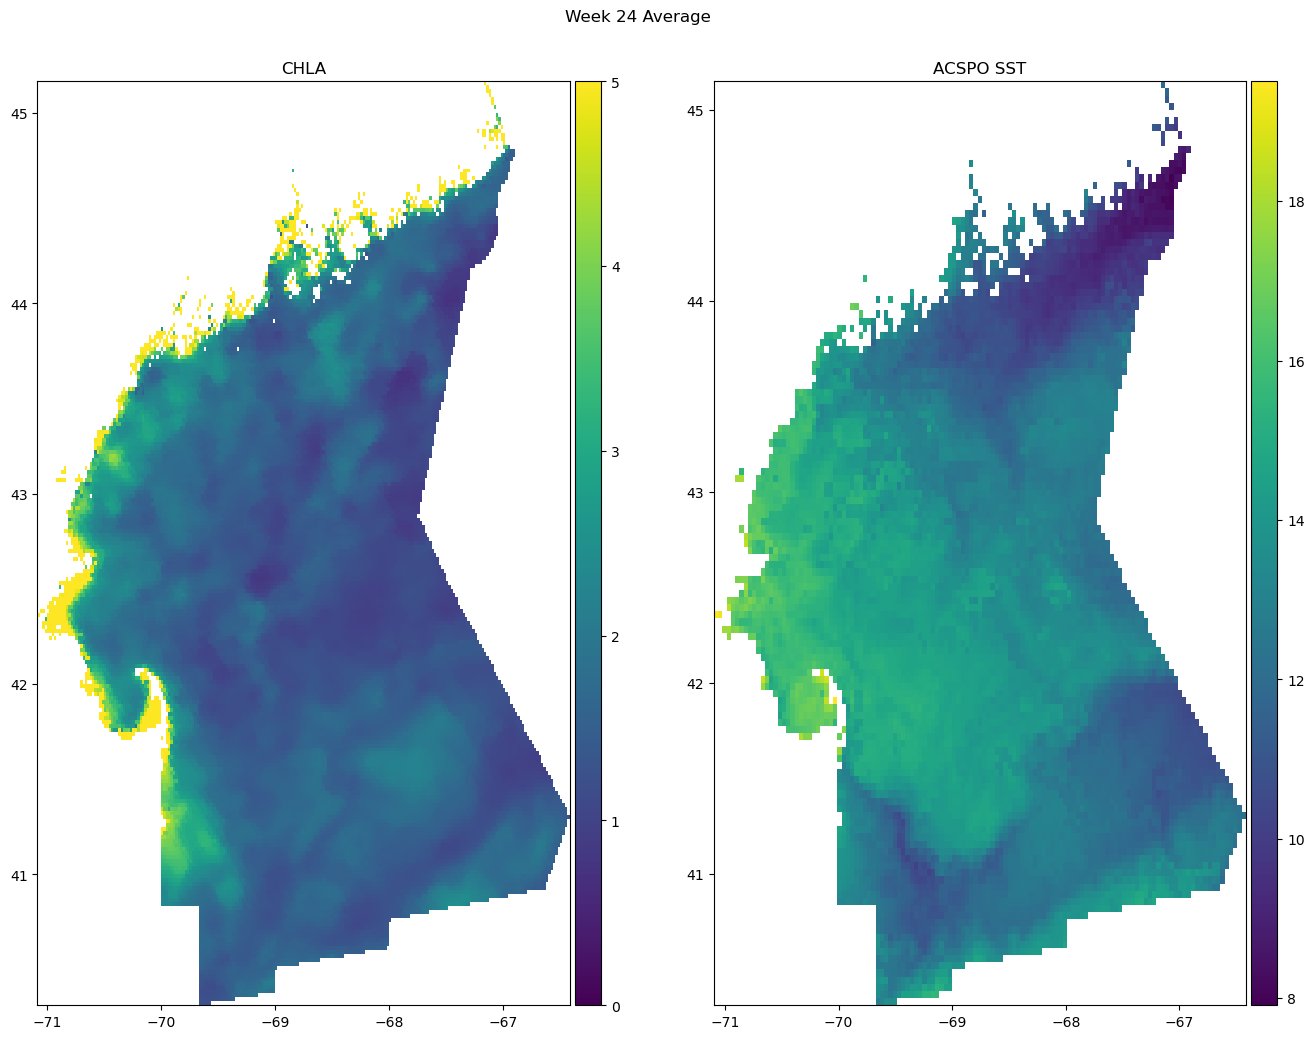

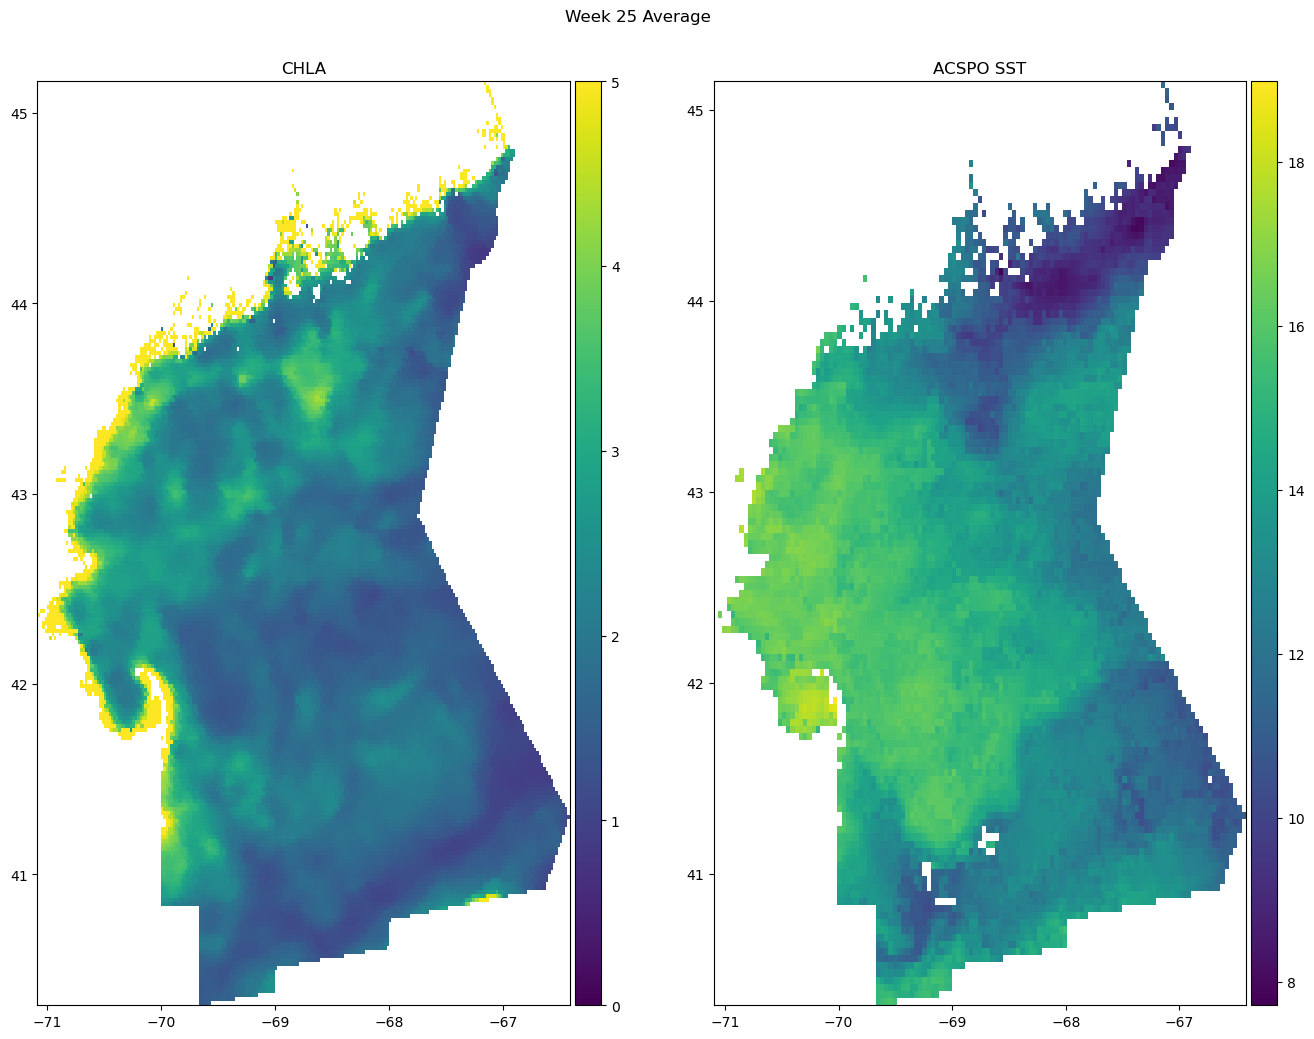

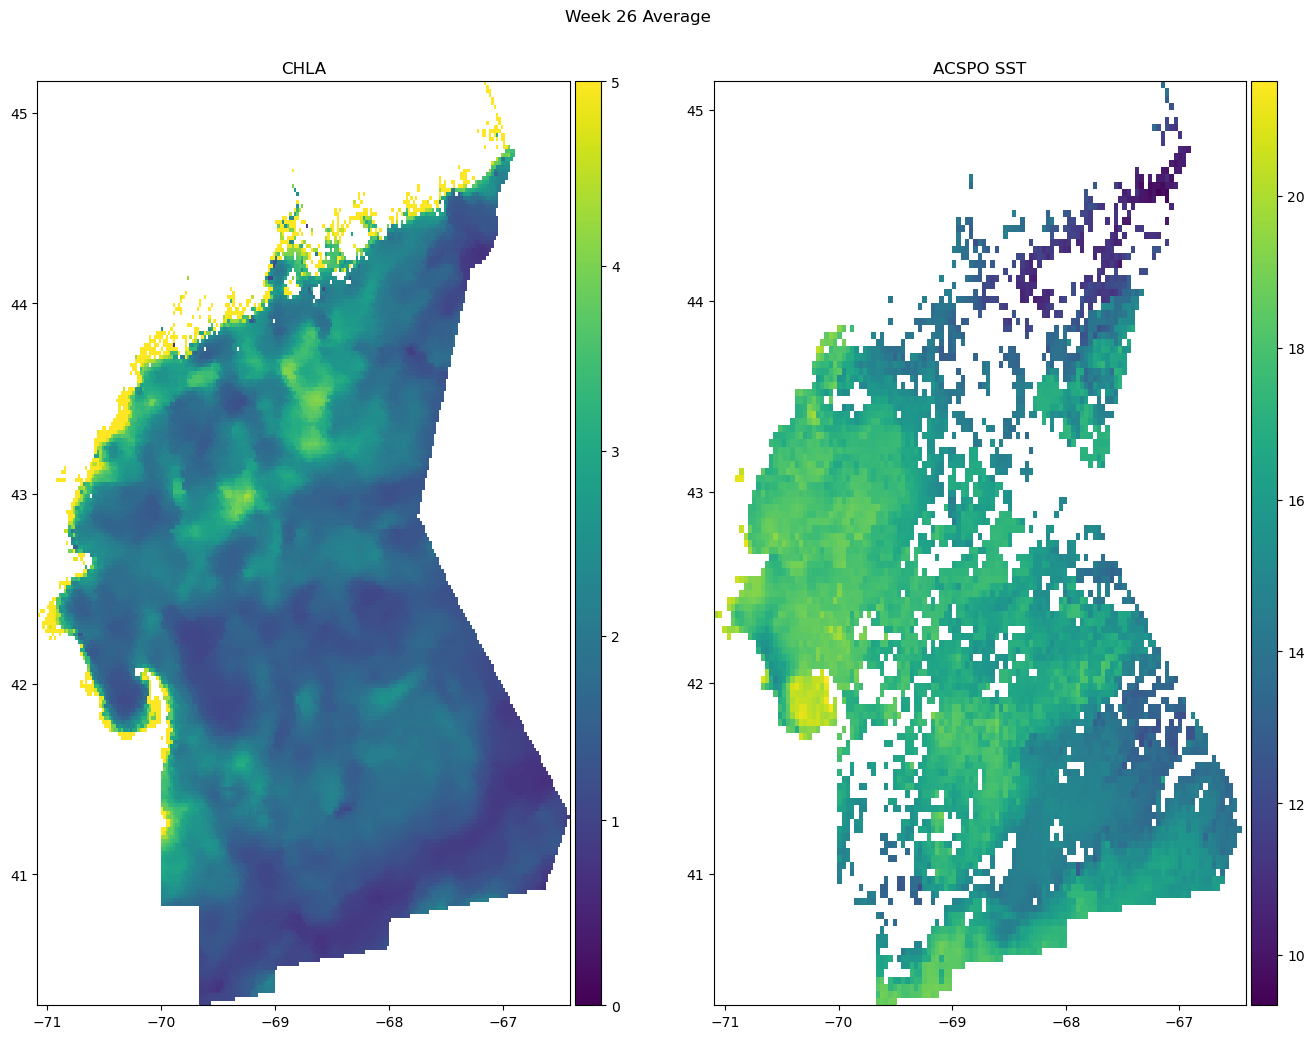

In [184]:
for x in range(len(sst_sub.groupby("time.week").mean().week)):
    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(121)
    im1 = ax1.pcolormesh(chla_sub.longitude,chla_sub.latitude,chla_sub.groupby("time.week").mean().chlor_a[x][0],vmin=0,vmax=5) 
    ax1.set_title("CHLA")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    ax2 = fig.add_subplot(122)
    im2 = ax2.pcolormesh(sst_sub.longitude,sst_sub.latitude,sst_sub.groupby("time.week").mean().sea_surface_temperature[x][0]) 
    ax2.set_title("ACSPO SST")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    fig.suptitle('Week '+ str(sst_sub.groupby("time.week").mean().week[x].data)+' Average', y=.94)
    plt.show()

C:\Users\haley.synan\AppData\Local\anaconda3\Lib\site-packages\xarray\core\dataset.py:228: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data


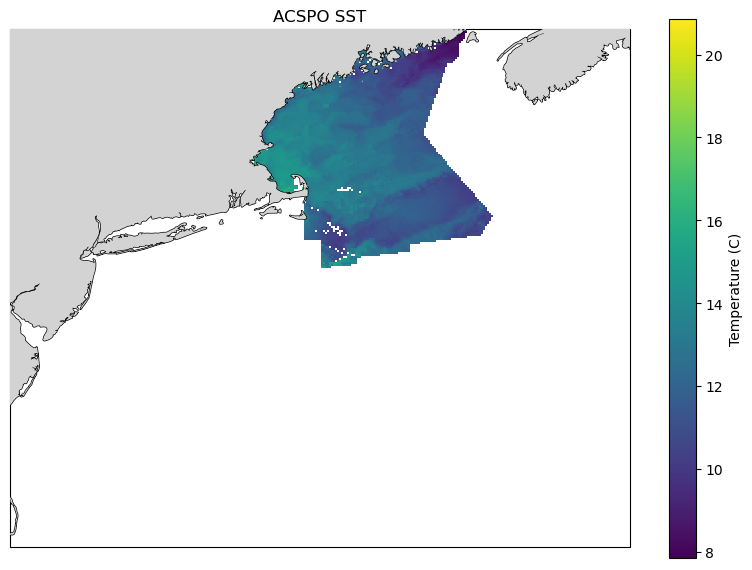

In [120]:
fig = plt.figure(figsize=(10, 7)) 
map_projection = cartopy.crs.PlateCarree() 
ax = plt.axes(projection=map_projection) 
im =ax.pcolormesh(sst_sub.longitude,sst_sub.latitude,sst_sub.groupby("time.week").mean().sea_surface_temperature[0][0]) #set variables to plot
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
cb = plt.colorbar(im,label="Temperature (C)" )
plt.title('ACSPO SST')
ax.set_extent([-75.6, -63.8, 35, 44.85])